In [6]:
%display latex

# Integración Simpléctica - Método Stormer Verlet

Se declara la variedad simpléctica y la carta:

In [7]:
n = 2 #cantidad de grados de libertad
M=Manifold(2*n, name='M')

In [8]:
std.<x, y, px, py> = M.chart(r'x y px:p_x py:p_y', coord_restrictions= lambda x,y, px, py :x**2 + y**2 !=0); std

Chart (M, (x, y, px, py))

In [9]:
(x**2 + y**2>0).assume() #vamos a trabajar en una sola carta entonces podemos asumir que no está el origen
assumptions()

[x is real, y is real, px is real, py is real, x^2 + y^2 > 0]

La técnica que vamos a usar es llamada _Hamiltonian Splitting_, consiste en dividir el Hamiltoniano en varios Hamiltonianos cuyos flows puedan ser calculados de manera exacta y después componer los flows para aproximar el flow del Hamiltoniano inicial. Para nuestro caso:

$$
H(\mathbf{q},\mathbf{p}) = H_T(\mathbf{p}) + H_V(\mathbf{q})
$$
Para nuestro caso el hamiltoniano es 
$$H(\mathbf{q},\mathbf{p}) = \frac{1}{2}\bigg( p_x^2 + p_y^2\bigg) - \frac{1}{\sqrt{x^2 + y^2}}$$
donde el modelo ya ha sido normalizado. 
$$H_T = \frac{1}{2}\bigg( p_x^2 + p_y^2\bigg)$$
$$H_V = - \frac{1}{\sqrt{x^2 + y^2}}$$
Nuestra siguiente tarea entonces es obtener los flujos de $H_V$ y$H_T$, el primer paso para esto es construir el campo vectorial asoaciado con cada Hamiltoniano.

In [5]:
#m = 1
#g = 10

In [10]:
#caida libre
#H_V = M.scalar_field( m*g*y , name='H_V' )
H_V = M.scalar_field(-1/sqrt(x**2 + y**2), name=r'H_V')
H_V.display()

H_V: M → ℝ
   (x, y, px, py) ↦ -1/sqrt(x^2 + y^2)

In [11]:
H_T = M.scalar_field( (px^2 +py^2)/2  , name='H_T' )
H_T.display()

H_T: M → ℝ
   (x, y, px, py) ↦ 1/2*px^2 + 1/2*py^2

In [12]:
from sage.manifolds.operators import *

In [13]:
latex(M.default_frame())

\left(M, \left(\frac{\partial}{\partial x },\frac{\partial}{\partial y },\frac{\partial}{\partial {p_x} },\frac{\partial}{\partial {p_y} }\right)\right)

Recordemos que tenemos el siguiente isomorfismo ($\omega^{\sharp}$ se ve muy feo entonces lo pongo como $\beta$)
$$
\begin{align*}
  \beta \colon TM & \longrightarrow T^{*}M \\
  a_\alpha \frac{\partial}{\partial q_\alpha} +  b_\alpha \frac{\partial}{\partial p_\alpha} & \longmapsto 
  b_\alpha dq_\alpha - a_\alpha dp_\alpha
\end{align*}
$$
el cual es facilmente invertible para que nos de la conexión entre los diferenciales de $H_V$ y $H_T$ con sus respectivos campos vectoriales hamiltonianos, los cuales después usaremos para obtener los flows de cada uno.
$$
\begin{align*}
  \beta^{-1} \colon T^{*}M & \longrightarrow TM \\
  a_\alpha dq_\alpha + b_\alpha dp_\alpha & \longmapsto -b_\alpha \frac{\partial}{\partial q_\alpha}+ a_\alpha \frac{\partial}{\partial p_\alpha}
  \end{align*}
$$
Pasamos ahora a definir $\beta^{-1}$ en Sage con el nombre de beta_inverse 

In [14]:
'''Función que recibe una 1-forma(diferencial) y retorna un campo vectorial. El campo es definido en el frame por 
    defecto de la variedad M sobre la que está definida la forma'''
def beta_inverse(alpha):
    M = alpha.domain()
    e = M.default_frame()
    ##hasta donde revisé, no hay una forma más simple de acceder a los componentes de la forma.
    ##Me faltó revisar la documentación de campos tensoriales, a lo mejor allá hablan algo de eso.
    #OJO: Se asume que la variedad es de dimensión par y el marco por defecto es la base canónica.
    n= M.dimension()
    X_alpha_q = sum(-alpha(e[i+n/2])*e[i] for i in range(0,n/2))
    X_alpha_p = sum(alpha(e[i])*e[i+n/2] for i in range(0,n/2))
    X_alpha = X_alpha_q + X_alpha_p
    return X_alpha

Se realiza la derivada exterior de los hamiltonianos y sus coeficientes se acomodan para obtener los campos hamiltonianos $ \mathbf{X_T} $ y $ \mathbf{X_V} $.

Se realiza la derivada exterior de los hamiltonianos y se obtienen los campos atravez de $\beta^{-1}$.

In [15]:
dH_V = H_V.differential()
dH_T = H_T.differential()

In [16]:
dH_V.display()

dH_V = x/(x^2 + y^2)^(3/2) dx + y/(x^2 + y^2)^(3/2) dy

In [17]:
dH_T.display()

dH_T = px dpx + py dpy

Nota para Federico: pilla que con beta_inverse sí se obtienen los mismos campos que manualmente.

In [18]:
X_T = beta_inverse(dH_T)
X_V = beta_inverse(dH_V)

In [19]:
X_T.display()

-dH_T(∂/∂px)*∂/∂x+-dH_T(∂/∂py)*∂/∂y+dH_T(∂/∂x)*∂/∂px+dH_T(∂/∂y)*∂/∂py = -px ∂/∂x - py ∂/∂y

In [18]:
X_V.display()

-dH_V(∂/∂px)*∂/∂x+-dH_V(∂/∂py)*∂/∂y+dH_V(∂/∂x)*∂/∂px+dH_V(∂/∂y)*∂/∂py = x/(x^2 + y^2)^(3/2) ∂/∂px + y/(x^2 + y^2)^(3/2) ∂/∂py

In [22]:
X_V[2]

x/(x^2 + y^2)^(3/2)

Podemos dar una respuesta general para la forma de los flows:
$$\psi_{H_T}^{\Delta t} (q,p) = \bigg(q + \frac{\partial H_T}{\partial p}(p) \Delta t, p \bigg) $$
$$\psi_{H_V}^{\Delta t} (q,p) = \bigg(q , p  -\frac{\partial H_V}{\partial q}(q)  \Delta t\bigg) $$

# Método Euler simpléctico
Este esquema de aproximación consiste en sencillamente combinar los flujos de $H_V$ y $H_T$ y es de primer orden [see, Munro]

Para nuestra suerte los flujos siempre se pueden obtener sin tener que resolver numéricamente (este era el chiste de escoger T(p) + H(q)), pasamos ahora a escribirlos usando las componentes de los campos vectoriales  


$$\psi_{H_T}^{\Delta t} (q,p) = (x + p_x\Delta t, y + p_y\Delta t , p_x, p_y) $$
Este siempre tendrá esta forma si $H_T$ dependen solo de $p$ y además es una forma cuadrática diagonal.
$$\psi_{H_V}^{\Delta t} (q,p) = (x, y, p_x + \frac{x\Delta t}{(x^2+y^2)^{3/2}}, p_y + \frac{y\Delta t}{(x^2+y^2)^{3/2}}) $$
En principio no es díficil escribir un resultado general para este caso en que solo se divide en dos Hamiltonianos, $H_T$ no depende de $q$ y $H_V$ no depende de $p$. Decimos que son separables en este sentido, que debe notarse es parecido pero distinto a la noción de separabilidad de la que se habla en teoría de HJ.
Lo siguiente es componer, podemos hacerlo de forma simbólica


In [20]:
#Voy a intentar definirlos dentro de Sage
dt = var('dt', latex_name = r'\Delta t')
Psi_T = M.diff_map(M, [x + px * dt ,y + py * dt, px, py], latex_name=r"\psi_{H_T}^{\Delta t}")
Psi_T.display()

M → M
   (x, y, px, py) ↦ (dt*px + x, dt*py + y, px, py)

In [21]:
Psi_V = M.diff_map(M, [x, y, -(x* dt)/(x^2 + y^2)^(3/2) + px, -(y*dt)/(x^2 + y^2)^(3/2) + py], 
                       latex_name=r"\psi_{H_V}^{\Delta t}")
Psi_V.display()

M → M
   (x, y, px, py) ↦ (x, y, px - dt*x/(x^2 + y^2)^(3/2), py - dt*y/(x^2 + y^2)^(3/2))

In [22]:
Psi = Psi_T * Psi_V
Psi.display(std)

M → M
   (x, y, px, py) ↦ (-(dt^2*x - (dt*px*x^2 + x^3 + (dt*px + x)*y^2)*sqrt(x^2 + y^2))/(x^2 + y^2)^(3/2), -(dt^2*y - (dt*py*x^2 + dt*py*y^2 + x^2*y + y^3)*sqrt(x^2 + y^2))/(x^2 + y^2)^(3/2), -(dt*x - (px*x^2 + px*y^2)*sqrt(x^2 + y^2))/(x^2 + y^2)^(3/2), -(dt*y - (py*x^2 + py*y^2)*sqrt(x^2 + y^2))/(x^2 + y^2)^(3/2))

Ahora podemos proceder a introducir el método numérico como tal

In [23]:
#definimos las expresiones mediante fast_callable para que podamos evaluar no solo los puntos sino también dt
expressions = Psi.expr()
psi_x = fast_callable(expressions[0], vars=[x,y, px, py, dt])
psi_y = fast_callable(expressions[1], vars=[x,y, px, py, dt])
psi_px = fast_callable(expressions[2], vars=[x,y, px, py, dt])
psi_py = fast_callable(expressions[3], vars=[x,y, px, py, dt])

In [24]:
#vamos a necesitar numpy y matplotlib para lo que sigue
import numpy as np
import matplotlib.pyplot as plt

In [30]:
#definimos donde vamos a guardar la información 

N = 1000 #pasos
h = 0.01 #tamaño del paso
data_x = np.zeros(N,)
data_y = np.zeros(N,) #esto se puede abreviar con un solo array más grande
data_px = np.zeros(N,)
data_py = np.zeros(N,)
x0, y0, px0, py0 = (0.4,0.,0,2.) #condiciones iniciales


In [26]:
#añadimos las condiciones iniciales al principio de cada data array
data_x[0] = x0
data_y[0] = y0
data_px[0] = px0
data_py[0] = py0

In [27]:
for k in range(1,N): #quizá esto no es la mejor forma de hacer esto pero ajá
    x_k = data_x[k-1]
    y_k = data_y[k-1]
    px_k = data_px[k-1]
    py_k = data_py[k-1]
    
    data_x[k] = psi_x(x_k, y_k, px_k, py_k, h)
    data_y[k] = psi_y(x_k, y_k, px_k, py_k, h)
    data_px[k] = psi_px(x_k, y_k, px_k, py_k, h)
    data_py[k] = psi_py(x_k, y_k, px_k, py_k, h)

In [28]:
p = M.point((x0,y0,px0,py0))
H_V(p)

-2.5

[<matplotlib.lines.Line2D object at 0x7f1a20c28040>]

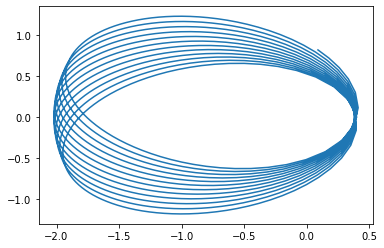

In [29]:
plt.plot(data_x, data_y)

In [30]:
fast_callable(Psi.expr()[0], vars=[x,y, px, dt])

array(1)

Stormer Verlet
$$
  \exp \left( \frac{1}{2} \Delta t X_V \right) \exp \left( \Delta t X_T \right)\exp \left( \frac{1}{2} \Delta t X_V \right)
$$
Para la introducción de este debemos de modificar ligeramente los flujos para dar cuenta de las constantes introducidas.

In [71]:
dt = var('dt', latex_name = r'\Delta t')
Psi_T = M.diff_map(M, [x + px * dt ,y + py * dt, px, py], latex_name=r"\psi_{H_T}^{\Delta t}")
Psi_T.display()

M → M
   (x, y, px, py) ↦ (dt*px + x, dt*py + y, px, py)

In [72]:
Psi_V_modified = M.diff_map(M, [x, y, (x* dt)/(2*(x^2 + y^2)^(3/2)) + px, (y*dt)/(2*(x^2 + y^2)^(3/2)) + py], 
                       latex_name=r"\psi_{0.5H_V}^{\Delta t}")
Psi_V_modified.display()

M → M
   (x, y, px, py) ↦ (x, y, px + 1/2*dt*x/(x^2 + y^2)^(3/2), py + 1/2*dt*y/(x^2 + y^2)^(3/2))

In [73]:
storm_verlet_integrator = Psi_V_modified * Psi_T * Psi_V_modified

In [91]:
storm_verlet_integrator.expr()[0].simplify_full()

1/2*(dt^2*x + 2*(dt*px*x^2 + x^3 + (dt*px + x)*y^2)*sqrt(x^2 + y^2))/(x^2 + y^2)^(3/2)

In [79]:
#definimos las expresiones mediante fast_callable para que podamos evaluar no solo los puntos sino también dt
expressions = storm_verlet_integrator.expr()
psi_x = fast_callable(expressions[0], vars=[x,y, px, py, dt])
psi_y = fast_callable(expressions[1], vars=[x,y, px, py, dt])
psi_px = fast_callable(expressions[2], vars=[x,y, px, py, dt])
psi_py = fast_callable(expressions[3], vars=[x,y, px, py, dt])

In [80]:
#vamos a necesitar numpy y matplotlib para lo que sigue
import numpy as np
import matplotlib.pyplot as plt

In [81]:
#definimos donde vamos a guardar la información 

N = 1000 #pasos
h = 0.1 #tamaño del paso
data_x = np.zeros(N,)
data_y = np.zeros(N,) #esto se puede abreviar con un solo array más grande
data_px = np.zeros(N,)
data_py = np.zeros(N,)
x0, y0, px0, py0 = (0.3,0,0,0.1) #condiciones iniciales


In [82]:
#añadimos las condiciones iniciales al principio de cada data array
data_x[0] = x0
data_y[0] = y0
data_px[0] = px0
data_py[0] = py0

In [83]:
for k in range(1,N): #quizá esto no es la mejor forma de hacer esto pero ajá
    x_k = data_x[k-1]
    y_k = data_y[k-1]
    px_k = data_px[k-1]
    py_k = data_py[k-1]
    
    data_x[k] = psi_x(x_k, y_k, px_k, py_k, h)
    data_y[k] = psi_y(x_k, y_k, px_k, py_k, h)
    data_px[k] = psi_px(x_k, y_k, px_k, py_k, h)
    data_py[k] = psi_py(x_k, y_k, px_k, py_k, h)

[<matplotlib.lines.Line2D object at 0x7f98f09ba280>]

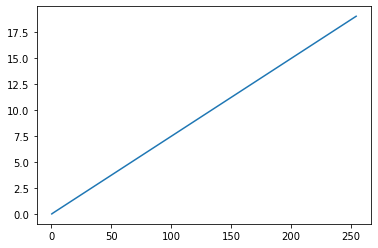

In [84]:
plt.plot(data_x,data_y)

from sage.calculus.desolvers import desolve_odeint

#condiciones iniciales y tamaño del paso
dT=0.001

x0 = 10
y0 = 0
px0 = 1
py0 = 1

x,y,px,py = var('x,y,px,py')

sol1 = desolve_odeint([X_V[0].expr()/2,X_V[1].expr()/2,X_V[2].expr()/2,X_V[3].expr()/2],[x0,y0,px0,py0],srange(0,2*dT,dT),[x,y,px,py])



from sage.calculus.desolvers import desolve_odeint

dT=0.01

x0 = 0
y0 = 0
px0 = 1
py0 = 1

x,y,px,py = var('x,y,px,py')

sol2 = desolve_odeint([X_T[0].expr(),X_T[1].expr(),X_T[2].expr(),X_T[3].expr()],sol1[1,:],srange(0,2*dT,dT),[x,y,px,py])

from sage.calculus.desolvers import desolve_odeint

dT=0.001

x0 = 0
y0 = 0
px0 = 1
py0 = 1

x,y,px,py = var('x,y,px,py')

sol3 = desolve_odeint([X_V[0].expr()/2,X_V[1].expr()/2,X_V[2].expr()/2,X_V[3].expr()/2],sol2[1,:],srange(0,2*dT,dT),[x,y,px,py])

In [22]:
from sage.calculus.desolvers import desolve_odeint
import numpy as np

dT=0.001

x0 = 0
y0 = 10
px0 = 1
py0 = 1

x,y,px,py = var('x,y,px,py')

t=1000

sol = np.zeros((int(t/dT),4))

for i in range(0,int(t/dT)):
    sol1 = desolve_odeint([X_V[0].expr()/2, ##componentes del campo vectorial al que le vamos a sacar 
                           X_V[1].expr()/2, ##el flujo.
                           X_V[2].expr()/2,
                           X_V[3].expr()/2],
                          [x0,y0,px0,py0], #condiciones iniciales
                          srange(0,2*dT,dT), #
                          [x,y,px,py])
    
    sol2 = desolve_odeint([X_T[0].expr(), #componentes del campo
                           X_T[1].expr(),
                           X_T[2].expr(),
                           X_T[3].expr()],
                           sol1[1,:],  #encontrar la solución en lo mismos puntos que se hizo para sol1
                           srange(0,2*dT,dT),
                          [x,y,px,py])
    
    sol3 = desolve_odeint([X_V[0].expr()/2,
                           X_V[1].expr()/2,
                           X_V[2].expr()/2,
                           X_V[3].expr()/2],
                           sol2[1,:], #encontrar la solución en los mismos puntos que se hizo para sol
                           srange(0,2*dT,dT),
                           [x,y,px,py])
    x0 = sol3[1,0]
    y0 = sol3[1,1]
    px0 = sol3[1,2]
    py0 = sol3[1,3]
    sol[i,:] = sol3[1,:]
    
print(sol)

KeyboardInterrupt: 

In [ ]:
sol[:,1]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

t1 = np.linspace(0,t,int(t/dT))

plt.plot(sol[:,0],sol[:,1],'k')
plt.plot(t1, -t1**2 *(g/2) + t1 + 10,'r')
plt.show()
